In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from zipfile import ZipFile
work_dir = os.getcwd()                                                  #Сохраняет текущий рабочий каталог.
with ZipFile(os.path.join(work_dir ,'/content/drive/MyDrive/Colab Notebooks/archive.zip'),'r') as zipobject:
  zipobject.extractall()                                                #Распакование загруженного набора данных.

In [ ]:
train_dir = os.path.join(work_dir,'train')       #Путь к каталогу train.
test_dir = os.path.join(work_dir,'test')         #Путь к тестовому каталогу.
os.makedirs(train_dir, exist_ok=True)  #Создание каталога для обучающих примеров.
os.makedirs(test_dir, exist_ok=True)   #Создание каталога для тестирования примеров.

In [ ]:
train_ratio=0.8
test_ratio=0.2
dir_list=os.listdir(os.path.join(work_dir ,'105_classes_pins_dataset'))
print('The Number of Classes in the Dataset is:{}'.format(len(dir_list)))

The Number of Classes in the Dataset is:105


In [ ]:
#Этот код разделит распакованный набор данных на обучающий и тестовый наборы в соответствии со значениями train_ratio и test_ratio.
from shutil import copyfile
import numpy as np

source_dir = os.path.join(work_dir ,'105_classes_pins_dataset')        #Распакованный каталог набора данных

dir_list = os.listdir(source_dir)

for folder in dir_list:
    data_dir = os.listdir(os.path.join(source_dir,folder))
    np.random.shuffle(data_dir)                            #Перетасовка примеров классов внутри набора данных.
    os.makedirs(os.path.join(train_dir , folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir , folder), exist_ok=True)
    train_data = data_dir[:int(len(data_dir)*train_ratio+1)] #Разделение обучающего набора данных по отношению к train_ratio.
    test_data = data_dir[-int(len(data_dir)*test_ratio):]

    for image in train_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(train_dir,folder,image)) #Копирование обучающих файлов из набора данных в каталог обучения.

    for image in test_data:
       copyfile(os.path.join(source_dir,folder,image) , os.path.join(test_dir,folder,image))  #Копирование обучающих файлов из набора данных в каталог обучения.


In [ ]:

print("The Number of Classes in the Training Set:{}".format(len(os.listdir(train_dir))))
print("The Number Of Classes in the Testing Set:{}".format(len(os.listdir(test_dir))))
print('For Verification of the Split.....')
print("The Number of Examples in the Class='pins_Katherine Langford' in the Dataset Directory:{}".format(len(os.listdir(os.path.join(source_dir,'pins_Katherine Langford')))))
print("The Number of Examples in the Class='pins_Katherine Langford' in the Train Directory:{}".format(len(os.listdir(os.path.join(train_dir,'pins_Katherine Langford')))))
print("The Number of Examples in the Class='pins_Katherine Langford' in the Test Directory:{}".format(len(os.listdir(os.path.join(test_dir,'pins_Katherine Langford')))))


The Number of Classes in the Training Set:105
The Number Of Classes in the Testing Set:105
For Verification of the Split.....
The Number of Examples in the Class='pins_Katherine Langford' in the Dataset Directory:226
The Number of Examples in the Class='pins_Katherine Langford' in the Train Directory:181
The Number of Examples in the Class='pins_Katherine Langford' in the Test Directory:45


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rows=160  #Количество пикселей в строках для ввода.
cols=160  #Количество пикселей в столбцах для вывода.

In [ ]:
trained_model=MobileNetV2(input_shape=(rows,cols,3),
                    include_top=False,
                    weights='imagenet')


trained_model.trainable=True  #Разморозка всех предварительно подготовленных слоев Mobile Net V2 для обучения.

trained_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [ ]:
last_layer=trained_model.get_layer('out_relu')
last_layer_output=last_layer.output  #Сохраняет выходные данные последнего уровня Mobile Net V2.

In [ ]:
#Функция обратного вызова, которая прекращает обучение, когда точность достигает 98%.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks=myCallback()

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)

x = tf.keras.layers.Dropout(0.8)(x)

x = tf.keras.layers.Dense(105,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Краткое описание модели.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']        

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1) # создание генератора обучающих данных (train_datagen) с использованием класса ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(rows,cols),
                                                  class_mode='categorical') #метод загружает изображения из указанной директории и применяет определенные трансформации

test_generator=test_datagen.flow_from_directory(test_dir,
                                                target_size=(rows,cols),
                                                class_mode='categorical') # Аналогично создается генератор тестовых данных (test_generator) для директории тестовых данных

Found 14084 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


In [ ]:
result=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=50,
                 callbacks=[callbacks],
                 verbose=1) #процесс обучения модели с использованием метода fit

Epoch 1/50
441/441 [==============================] - 189s 345ms/step - loss: 5.0517 - accuracy: 0.0152 - val_loss: 4.6928 - val_accuracy: 0.0245
Epoch 2/50
441/441 [==============================] - 137s 311ms/step - loss: 4.5219 - accuracy: 0.0307 - val_loss: 4.2716 - val_accuracy: 0.0474
Epoch 3/50
441/441 [==============================] - 136s 307ms/step - loss: 4.2334 - accuracy: 0.0512 - val_loss: 3.8618 - val_accuracy: 0.0970
Epoch 4/50
441/441 [==============================] - 141s 319ms/step - loss: 3.8390 - accuracy: 0.1058 - val_loss: 3.2786 - val_accuracy: 0.2056
Epoch 5/50
441/441 [==============================] - 139s 314ms/step - loss: 3.4242 - accuracy: 0.1690 - val_loss: 2.8527 - val_accuracy: 0.3061
Epoch 6/50
441/441 [==============================] - 137s 311ms/step - loss: 2.9941 - accuracy: 0.2478 - val_loss: 2.4471 - val_accuracy: 0.3884
Epoch 7/50
441/441 [==============================] - 138s 312ms/step - loss: 2.5787 - accuracy: 0.3296 - val_loss: 2.2349 -

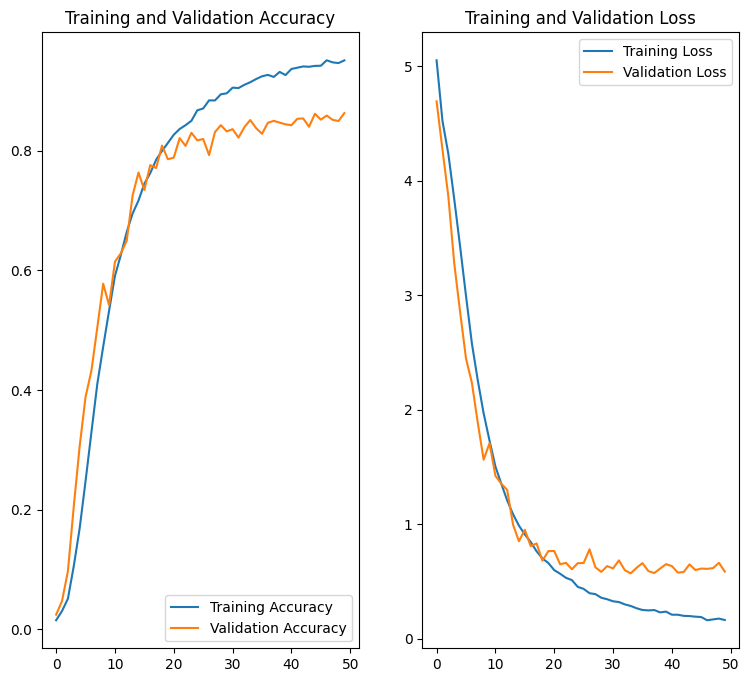

In [ ]:
#построение графиков, отображающих точность и функцию потерь как на обучающих, так и на валидационных данных в течение каждой эпохи обучения
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/32.jpg"  #Путь к целевому изображению, подлежащему прогнозированию.

classes=train_generator.class_indices
class_names=list(classes.keys())   #Список имен классов.
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(rows, cols)
)

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array=img_array/255.

score = model.predict(img_array)

print(
    "The Person in the Image is {} ."
    .format(class_names[np.argmax(score)][5:].title())
)

1/1 [==============================] - 2s 2s/step
The Person in the Image is Chris Pratt .
